In [1]:
# Code to plot the oracle
import matplotlib.pyplot as plt
# import seaborn as sns
import pickle
from tueplots import bundles
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
import pandas as pd
from spiro.learners import *

np.random.seed(0)
random.seed(0)

In [2]:
from tueplots import figsizes
figsizes.tmlr2023(nrows=2)["figure.figsize"]
plt.rcParams.update(bundles.tmlr2023(rel_width=0.7))

In [3]:
def al_loop(model,X_train, X_test, X_pool, Y_train, Y_test, Y_pool,strategy,pid,print_query_idx=False):
    scores = []
    learner = Learner(model, strategy, X_pool, Y_pool)
    learner.fit(X_train, Y_train)
    score, pred = learner.score(X_test, Y_test, "mape",print_score=True)
    std_list=[]
    pid_removed=[]
    new_pid= pid.copy()

    scores.append(score)
    for i in range(33):
        q, unc = learner.query(print_query_idx=print_query_idx)
        std_list.append(unc)
        learner.teach(q)
        pid_removed.append(new_pid[q])
        new_pid = np.delete(new_pid, q, axis=0)
        score, pred = learner.score(X_test, Y_test, "mape")
        scores.append(score)
    return scores,std_list,pid_removed

In [4]:
def train_pool_split(X, Y, train_idx, test_idx):
    pool_idx = [i for i in range(0, X.shape[0]) if i not in train_idx + test_idx]
    X_train, X_test, X_pool = X[train_idx], X[test_idx], X[pool_idx]
    Y_train, Y_test, Y_pool = Y[train_idx], Y[test_idx], Y[pool_idx]
    print("Shape of X_train = {} and Y_train = {}".format(X_train.shape, Y_train.shape))
    print("Shape of X_test = {} and Y_test = {}".format(X_test.shape, Y_test.shape))
    print("Shape of X_pool = {} and Y_pool = {}".format(X_pool.shape, Y_pool.shape))
    return X_train, X_test, X_pool, Y_train, Y_test, Y_pool


In [5]:
data = pd.read_csv("../data/feature_30_joint_51.csv")
data2 = pd.DataFrame(np.load("../data/Final_features_3k5k_order5_53.npy",allow_pickle=True))

In [6]:
data= data[~data.iloc[:,0].isin([21,48])].reset_index(drop=True)

In [7]:
data.drop("Unnamed: 0",axis=1,inplace=True)

In [8]:
remove = ['P1', 'P11', 'P22', 'P22', 'P25', 'P37', 'P4', 'P47', 'P48', 'P49', 'P54', 'P56', 'P59','P16', 'P24', 'P68', 'P72','P74','P75','P30','P67']
data2 = data2[~data2.iloc[:,0].isin(remove)]
data2.shape

(51, 713)

In [9]:
X= pd.DataFrame(data,dtype="float")
pid= data2.iloc[:,0].values

In [10]:
X = MinMaxScaler().fit_transform(X)
Y = data2.iloc[:,-1].astype("float")
Y = np.array(Y)

In [11]:
train_idx, test_idx= [1, 40, 38, 15, 45, 10, 19, 35], [0, 42, 30, 6, 17, 8, 33, 44, 11, 36]
pool_idx = [i for i in range(0, X.shape[0]) if i not in train_idx + test_idx]
pid = pid[pool_idx]

In [12]:
X_train, X_test, X_pool, Y_train, Y_test, Y_pool = train_pool_split(X, Y, train_idx, test_idx)

Shape of X_train = (8, 30) and Y_train = (8,)
Shape of X_test = (10, 30) and Y_test = (10,)
Shape of X_pool = (33, 30) and Y_pool = (33,)


In [13]:
# Random Sampling
rf = RandomForestRegressor(random_state=0) 
model = SklearnEnsemble(rf)
print("------------------Random Sampling------------------")
np.random.seed(0)
random.seed(0)
final_random_scores = []
for i in range(20):
    random_scores,_,_= al_loop(model,X_train, X_test, X_pool, Y_train, Y_test, Y_pool,"random",pid)
    final_random_scores.append(random_scores)

------------------Random Sampling------------------
Fitting the model on initial train data
MAPE score:  5.167366862181775
Fitting the model on initial train data
MAPE score:  5.167366862181775
Fitting the model on initial train data
MAPE score:  5.167366862181775
Fitting the model on initial train data
MAPE score:  5.167366862181775
Fitting the model on initial train data
MAPE score:  5.167366862181775
Fitting the model on initial train data
MAPE score:  5.167366862181775
Fitting the model on initial train data
MAPE score:  5.167366862181775
Fitting the model on initial train data
MAPE score:  5.167366862181775
Fitting the model on initial train data
MAPE score:  5.167366862181775
Fitting the model on initial train data
MAPE score:  5.167366862181775
Fitting the model on initial train data
MAPE score:  5.167366862181775
Fitting the model on initial train data
MAPE score:  5.167366862181775
Fitting the model on initial train data
MAPE score:  5.167366862181775
Fitting the model on init

In [14]:
## load data using pickle file
with open("../results/figure12/oracle.pkl", "rb") as f:
    oracle = pickle.load(f)
    
oracle = np.array(oracle)

In [18]:
x = [i for i in range(0, 31)]
random_scores_array = np.array(final_random_scores)
random_mean = np.array(np.mean(random_scores_array, axis=0))
random_std = np.array(np.std(random_scores_array, axis=0))
oracle_actual = []
oracle_actual.append(random_mean[0])
oracle_actual.extend(oracle)

<>:9: SyntaxWarning: invalid escape sequence '\%'
<>:9: SyntaxWarning: invalid escape sequence '\%'
/var/folders/bx/05h8rp190_nbjjhsrq7qstq40000gn/T/ipykernel_5883/870923269.py:9: SyntaxWarning: invalid escape sequence '\%'
  x, random_mean[:31] - random_std[:31], random_mean[:31] + random_std[:31], color="cornflowerblue", label="95\% interval")


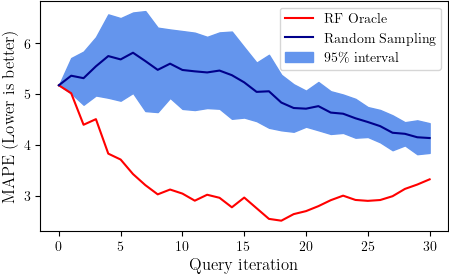

In [20]:
plt.rcParams['axes.labelsize']=12
plt.rcParams['legend.fontsize']=10
plt.rcParams['axes.titlesize']=12
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.plot(x,oracle_actual[:31],label="RF Oracle",color="red")
plt.plot(x, random_mean[:31], label="Random Sampling", color="darkblue")
plt.fill_between(
    x, random_mean[:31] - random_std[:31], random_mean[:31] + random_std[:31], color="cornflowerblue", label="95\% interval")
plt.legend()
plt.xlabel("Query iteration")
plt.ylabel("MAPE (Lower is better)")

plt.savefig("../figures/figure4.pdf",bbox_inches='tight')